<a href="https://www.kaggle.com/code/atifkhan12/melting-point-prediction?scriptVersionId=283358406" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melting-point/sample_submission.csv
/kaggle/input/melting-point/train.csv
/kaggle/input/melting-point/test.csv
/kaggle/input/melting-point-prediction/scikitlearn/default/1/melting_point_prediction.ipynb


<h1 style="color:pink">Import requried Libraries<h1>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.preprocessing import LabelEncoder,quantile_transform,StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

<h1 style="color:pink">Load Dataset</h1>

In [3]:
test=pd.read_csv("/kaggle/input/melting-point/test.csv")
df=pd.read_csv("/kaggle/input/melting-point/train.csv")

<h1 style="color:pink">Data Overview</h1>

In [4]:
df.head()

,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,id,SMILES,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,1022,CCOC(=O)c1ccc(O)cc1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1146,CCCCCCc1ccc(O)cc1O,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79,ClCBr,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2279,C=CCCCCCCCC,1,7,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1342,Fc1ccc(cc1)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print("Shape of training dataset:",df.shape)
print("Shape of testing dataset: ",test.shape)

Shape of training dataset: (2662, 427)
Shape of testing dataset:  (666, 426)


In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

id           0
SMILES       0
Tm           0
Group 1      0
Group 2      0
            ..
Group 420    0
Group 421    0
Group 422    0
Group 423    0
Group 424    0
Length: 427, dtype: int64

<h1 style="color:pink">Statistical Analysis</h1>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Columns: 427 entries, id to Group 424
dtypes: float64(1), int64(425), object(1)
memory usage: 8.7+ MB


In [10]:
df.describe()

,id,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
count,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,...,2662.000000,2662.000000,2662.0,2662.000000,2662.0,2662.0,2662.0,2662.0,2662.0,2662.0
mean,1652.887303,278.263452,1.020661,1.582269,0.114951,0.036439,0.036814,0.022915,0.013524,0.010143,...,0.001127,0.000751,0.0,0.001878,0.0,0.0,0.0,0.0,0.0,0.0
std,955.005512,85.117914,1.353640,3.738416,0.425964,0.208307,0.205516,0.164037,0.118732,0.117480,...,0.033558,0.027405,0.0,0.058126,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,53.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,830.250000,217.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,1642.500000,277.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,2469.750000,325.150000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,3328.000000,897.150000,16.000000,42.000000,6.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df['SMILES_len'] = df['SMILES'].str.len()

# (C=Carbon, O=Oxygen, N=Nitrogen, F=Fluorine, etc.)
patterns = ['C', 'O', 'N', 'F', 'S', 'Cl', 'Br', '=', '#', '\\(', '\\)', '1', '2', '3']
names =    ['C', 'O', 'N', 'F', 'S', 'Cl', 'Br', 'double_bond', 'triple_bond', 'open_p', 'close_p', 'ring1', 'ring2', 'ring3']

for pat, name in zip(patterns, names):
    df[f'count_{name}'] = df['SMILES'].str.count(pat)

In [12]:
test['SMILES_len'] = test['SMILES'].str.len()

# (C=Carbon, O=Oxygen, N=Nitrogen, F=Fluorine, etc.)
patterns = ['C', 'O', 'N', 'F', 'S', 'Cl', 'Br', '=', '#', '\\(', '\\)', '1', '2', '3']
names =    ['C', 'O', 'N', 'F', 'S', 'Cl', 'Br', 'double_bond', 'triple_bond', 'open_p', 'close_p', 'ring1', 'ring2', 'ring3']

for pat, name in zip(patterns, names):
    test[f'count_{name}'] = test['SMILES'].str.count(pat)

<h1 style="color:pink">Visualization Analysis</h1>

In [13]:
df['First_Char'] = df['SMILES'].str[0]
top_chars = df['First_Char'].value_counts().nlargest(10).index
df_top_chars = df[df['First_Char'].isin(top_chars)]

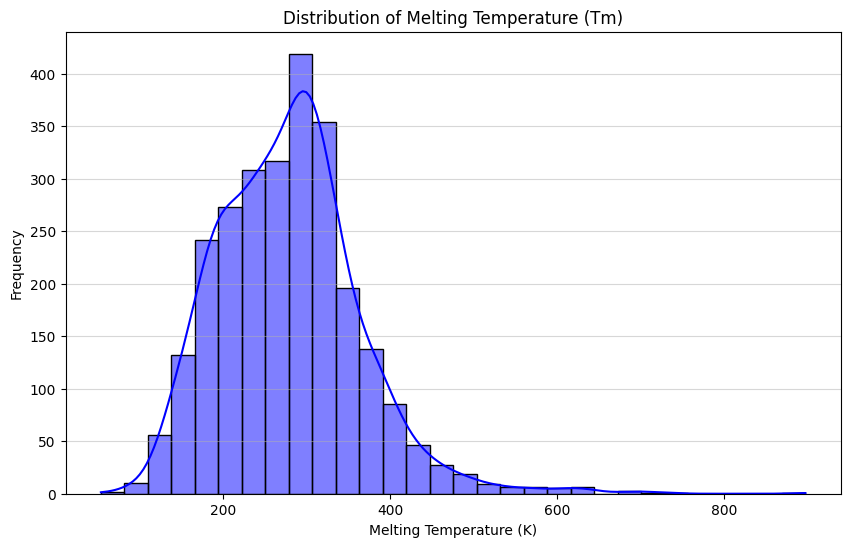

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Tm'], kde=True, color='blue', bins=30)
plt.title('Distribution of Melting Temperature (Tm)')
plt.xlabel('Melting Temperature (K)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

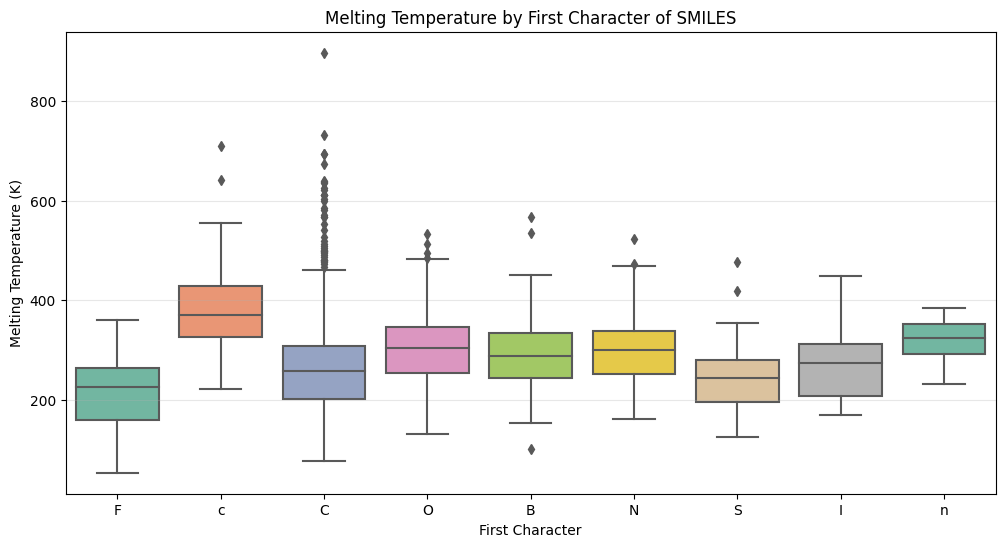

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='First_Char', y='Tm', data=df_top_chars, palette='Set2')
plt.title('Melting Temperature by First Character of SMILES')
plt.xlabel('First Character')
plt.ylabel('Melting Temperature (K)')
plt.grid(axis='y', alpha=0.3)
plt.show()

<h1 style="color:pink">Data Encoding</h1>

In [16]:
df['First_Char'] = df['SMILES'].str[0]
df = pd.get_dummies(df, columns=['First_Char'], drop_first=True)

test['First_Char'] = test['SMILES'].str[0]
test = pd.get_dummies(test, columns=['First_Char'], drop_first=True)

<h1 style="color:pink">Feature Selection</h1>

In [17]:
X = df.drop(columns=['id', 'SMILES', 'Tm'])
y = df['Tm']

<h1 style="color:pink">Train Test Split</h1>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h1 style="color:pink">fit the model</h1>

In [19]:
model = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=42,
    subsample=0.8
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

<h1 style="color:pink">Metrics</h1>

In [20]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print("-" * 30)
print("Model Performance Results:")
print("-" * 30)
print(f"R² Score (Variance Explained): {r2:.4f}")
print(f"Mean Absolute Error (MAE):     {mae:.2f}")
print(f"Mean Percentage Error (MAPE):  {mape:.2f}%")
print(f"Model Accuracy:   {accuracy:.2f}%")
print("-" * 30)

------------------------------
Model Performance Results:
------------------------------
R² Score (Variance Explained): 0.6697
Mean Absolute Error (MAE):     32.66
Mean Percentage Error (MAPE):  12.09%
Model Accuracy:   87.91%
------------------------------


<h1 style="color:pink">Final Submission</h1>

In [21]:
result=model.predict(test.drop(columns=['id', 'SMILES']))
sample_submission=pd.DataFrame({
    "id":test.id,
    "submission":result
})
sample_submission.head()

,id,submission
0,1022,335.169114
1,1146,308.500559
2,79,200.609534
3,2279,213.196866
4,1342,235.669738


In [22]:
sample_submission=sample_submission.to_csv("sample_submission.csv")
print("Submission is saved Successfully!")

Submission is saved Successfully!
